In [2]:
import re
import numpy as np
from pprint import pprint

# NLTK
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel, Nmf

# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline

# spacy for lemmatization
import spacy


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from helper_functions.utils import Utils
from config import common_stop_words

In [3]:
utilities = Utils()
so_posts = utilities.dataset_importer("../data/cleaned/cleaned_text.csv", "cleaned_text")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\muthu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
cleaned_text = so_posts["cleaned_text"]
cleaned_text.head()

0    new research field nlp want implement paper ar...
1    work standford core nlp package give set jar f...
2    look exist library summarize paraphrase conten...
3    new nltk machine learn use python nltk naive b...
4    try reproduce example article httpsmediumcomng...
Name: cleaned_text, dtype: object

In [5]:
stop_words = stopwords.words('english')
stop_words.extend(['00', 'from', 'subject', 're', 'edu', 'use','a','about', 'above', 'across', 'want', 'need', 'thank', 'know', 'like', 'use', 'try', 'help', 'work'])
stop_words.extend(common_stop_words)

# Preparing Data for Topic Modeling

In [6]:
so_posts["cleaned_text"] = so_posts["cleaned_text"].astype(str)
# Convert to list
df = so_posts.cleaned_text.values.tolist()

df = [re.sub('\S*@\S*\s?', '', sent) for sent in df]

# Remove new line characters
df = [re.sub('\s+', ' ', sent) for sent in df]

# Remove distracting single quotes
df = [re.sub("\'", "", sent) for sent in df]

pprint(df[:1])

['new research field nlp want implement paper artificial neural network learn '
 'language model paper first time step take neural network learn language '
 'model understand paper everything understandable confusions last section '
 'paper find code paper old even find train data communicator telephone air '
 'travel information system use time also email professors paper email id one '
 'expire wait response one anyone help situation guidelines would valuable new '
 'comers research field would thankful']


In [7]:
df = [re.sub("-", " ", sent) for sent in df]
df = [re.sub(":", "", sent) for sent in df]

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

df_words = list(sent_to_words(df))

In [9]:
# Build the bigram and trigram models

bigram = gensim.models.Phrases(df_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [10]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words

data_words_nostops = remove_stopwords(df_words)

# Form Bigrams

data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [13]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[11:12]]

[[('code', 1),
  ('execute', 1),
  ('file', 1),
  ('come', 1),
  ('create', 1),
  ('read', 1),
  ('error', 1),
  ('follow', 1),
  ('document', 1),
  ('folder', 1),
  ('notepad', 1),
  ('rest', 1),
  ('txt', 1),
  ('txttxt', 1)]]

# Topic Modeling Algorithms Comparison

In [14]:
NUM_TOPICS = 10

In [15]:
lsimodel = LsiModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=id2word)
lsitopics = lsimodel.show_topics(formatted=False)

In [17]:
hdpmodel = HdpModel(corpus=corpus, id2word=id2word)
hdptopics = hdpmodel.show_topics(num_topics=NUM_TOPICS, formatted=False)

In [18]:
lda_model = LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=id2word)
ldatopics = lda_model.show_topics(formatted=False)

In [19]:
nmf_model = Nmf(corpus=corpus, num_topics=NUM_TOPICS, id2word=id2word)
nmftopics = nmf_model.show_topics(formatted=False)

In [20]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]

nmftopics = [[word for word, prob in topic] for topicid, topic in nmftopics]

In [21]:
lsi_coherence = CoherenceModel(topics=lsitopics, texts=data_lemmatized, dictionary=id2word, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics, texts=data_lemmatized, dictionary=id2word, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=data_lemmatized, dictionary=id2word, window_size=10).get_coherence()

nmf_coherence = CoherenceModel(topics=nmftopics, texts=data_lemmatized, dictionary=id2word, window_size=10).get_coherence()

In [22]:
def evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.figure(figsize=(12,12))
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

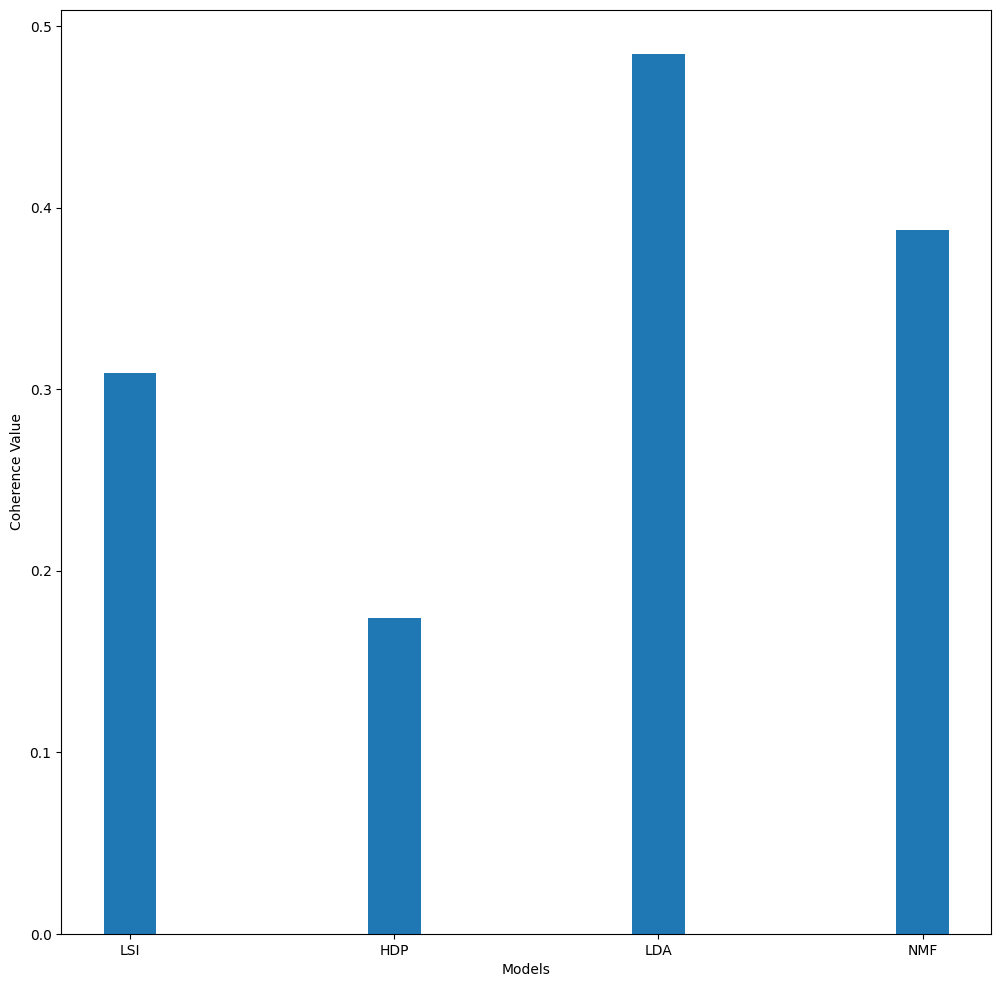

In [23]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence, nmf_coherence],
                   ['LSI', 'HDP', 'LDA', 'NMF'])

In [24]:
coherence_comparison = [lsi_coherence, hdp_coherence, lda_coherence, nmf_coherence]

In [25]:
coherence_comparison

[0.3086983427906972,
 0.17381302844249308,
 0.4847541865216323,
 0.387492581726783]

In [26]:
ldatopics

[['word',
  'text',
  'number',
  'frequency',
  'count',
  'character',
  'remove',
  'example',
  'list',
  'string'],
 ['document',
  'word',
  'term',
  'way',
  'similarity',
  'score',
  'result',
  'calculate',
  'similar',
  'cluster'],
 ['error',
  'code',
  'run',
  'follow',
  'issue',
  'problem',
  'version',
  'file',
  'package',
  'import'],
 ['entity',
  'example',
  'text',
  'match',
  'extract',
  'tag',
  'spacy',
  'way',
  'date',
  'question'],
 ['topic',
  'sentence',
  'document',
  'lda',
  'example',
  'word',
  'phrase',
  'text',
  'extract',
  'way'],
 ['train',
  'datum',
  'label',
  'dataset',
  'model',
  'set',
  'test',
  'feature',
  'classification',
  'text'],
 ['model',
  'vector',
  'word',
  'train',
  'input',
  'layer',
  'output',
  'embedding',
  'matrix',
  'sentence'],
 ['file',
  'application',
  'start',
  'user',
  'web',
  'run',
  'download',
  'server',
  'page',
  'deploy'],
 ['file',
  'text',
  'column',
  'list',
  'code',
  'o